<a href="https://colab.research.google.com/github/parkrye/Python/blob/main/202101_KNUBootCamp/%ED%95%AD%EA%B3%B5%EC%82%AC_%EB%A7%8C%EC%A1%B1%EB%8F%84_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics 
from sklearn.impute import KNNImputer
import warnings                         # warning메시지 무시
warnings.filterwarnings('ignore')
plt.rc("axes", unicode_minus = False)   # 음수부호 표시하도록 설정

#1.데이터 확인 및 고려사항 체크

In [ ]:
#1. 파일 로딩 및 확인
file_path = "/content/train.csv"
df = pd.read_csv(file_path)
original_df = pd.read_csv(file_path)
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target
0,1,Female,disloyal Customer,22,Business travel,Eco,1599,3,0,3,3,4,3,4,4,5,4,4,4,5,4,0,0.0,0
1,2,Female,Loyal Customer,37,Business travel,Business,2810,2,4,4,4,1,4,3,5,5,4,2,1,5,2,18,18.0,0
2,3,Male,Loyal Customer,46,Business travel,Business,2622,1,1,1,1,4,5,5,4,4,4,4,5,4,3,0,0.0,1
3,4,Female,disloyal Customer,24,Business travel,Eco,2348,3,3,3,3,3,3,3,3,2,4,5,3,4,3,10,2.0,0
4,5,Female,Loyal Customer,58,Business travel,Business,105,3,3,3,3,4,4,5,4,4,4,4,4,4,5,0,0.0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 3000 non-null   int64  
 1   Gender                             3000 non-null   object 
 2   Customer Type                      3000 non-null   object 
 3   Age                                3000 non-null   int64  
 4   Type of Travel                     3000 non-null   object 
 5   Class                              3000 non-null   object 
 6   Flight Distance                    3000 non-null   int64  
 7   Seat comfort                       3000 non-null   int64  
 8   Departure/Arrival time convenient  3000 non-null   int64  
 9   Food and drink                     3000 non-null   int64  
 10  Gate location                      3000 non-null   int64  
 11  Inflight wifi service              3000 non-null   int64

##1.1 데이터 확인 내용

1 Data type : Target(Binary) , Feature(0~5 int), 기타 Feature(int, Delay minutes / Distance / Age),  Object(Gender, Customer Type, Type of Travel, Class)

2 Target은 0&1의 binary로 표현된다.

  2-1. 배운 내용 중 Logistic regression (활성함수 sigmoid)이 적합 할 것이다.
        2-1-1. 다중공선성 제거(by 상관계수 & pair plot)
        2-1-2. 데이터 편중 여부 및 스케일 확인 (Data Histogram)


3 Feature(0~5 int) : null 값은 없음. 그러나, 0값이 존재하는데 이에 대한 처리 필요 할 것.  

  3-1. 점수상 0값이 null값 대신 입력된 것이 아닌가라는 가설 설정 및 검증.
        
  3-2. 0이 만약 null 값이라면 어떤 값으로 대체할 것인가?

4 기타 Feature 값 (Delay minutes / Distance / Age)

  4-1. Delay in Minuites

  4-2. Flight Distance

  4-3. Age

5 Object(Gender, Customer Type, Type of Travel, Class)

  5-1 만족도 점수에 반영하는 것은 부적합하므로, 분석 그룹 설정 지표로 사용하여 
      그룹별 차이가 나타나는지 확인해 보자.



#2.Logistic Regression을 위한 종속변수 확인 및

##2.1 다중공선성 확인 및 제거

방법: Pair Plot & 상관도 Heat map 확인

결론: Seat Comfort & Food and drink  /  Online Boarding & Online Support & Ease of Online Booking / Departure Delay in Minutes & Arrival Delay in Minutes 에서 다중공선성 확인

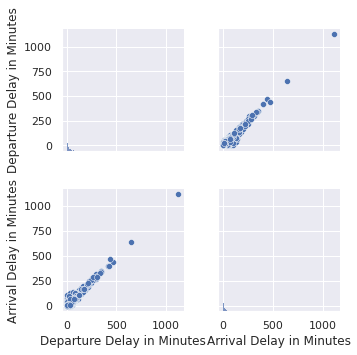

In [ ]:
#Pair plot
delay_coloumns = ['Departure Delay in Minutes','Arrival Delay in Minutes']
sns.pairplot(df[delay_coloumns])

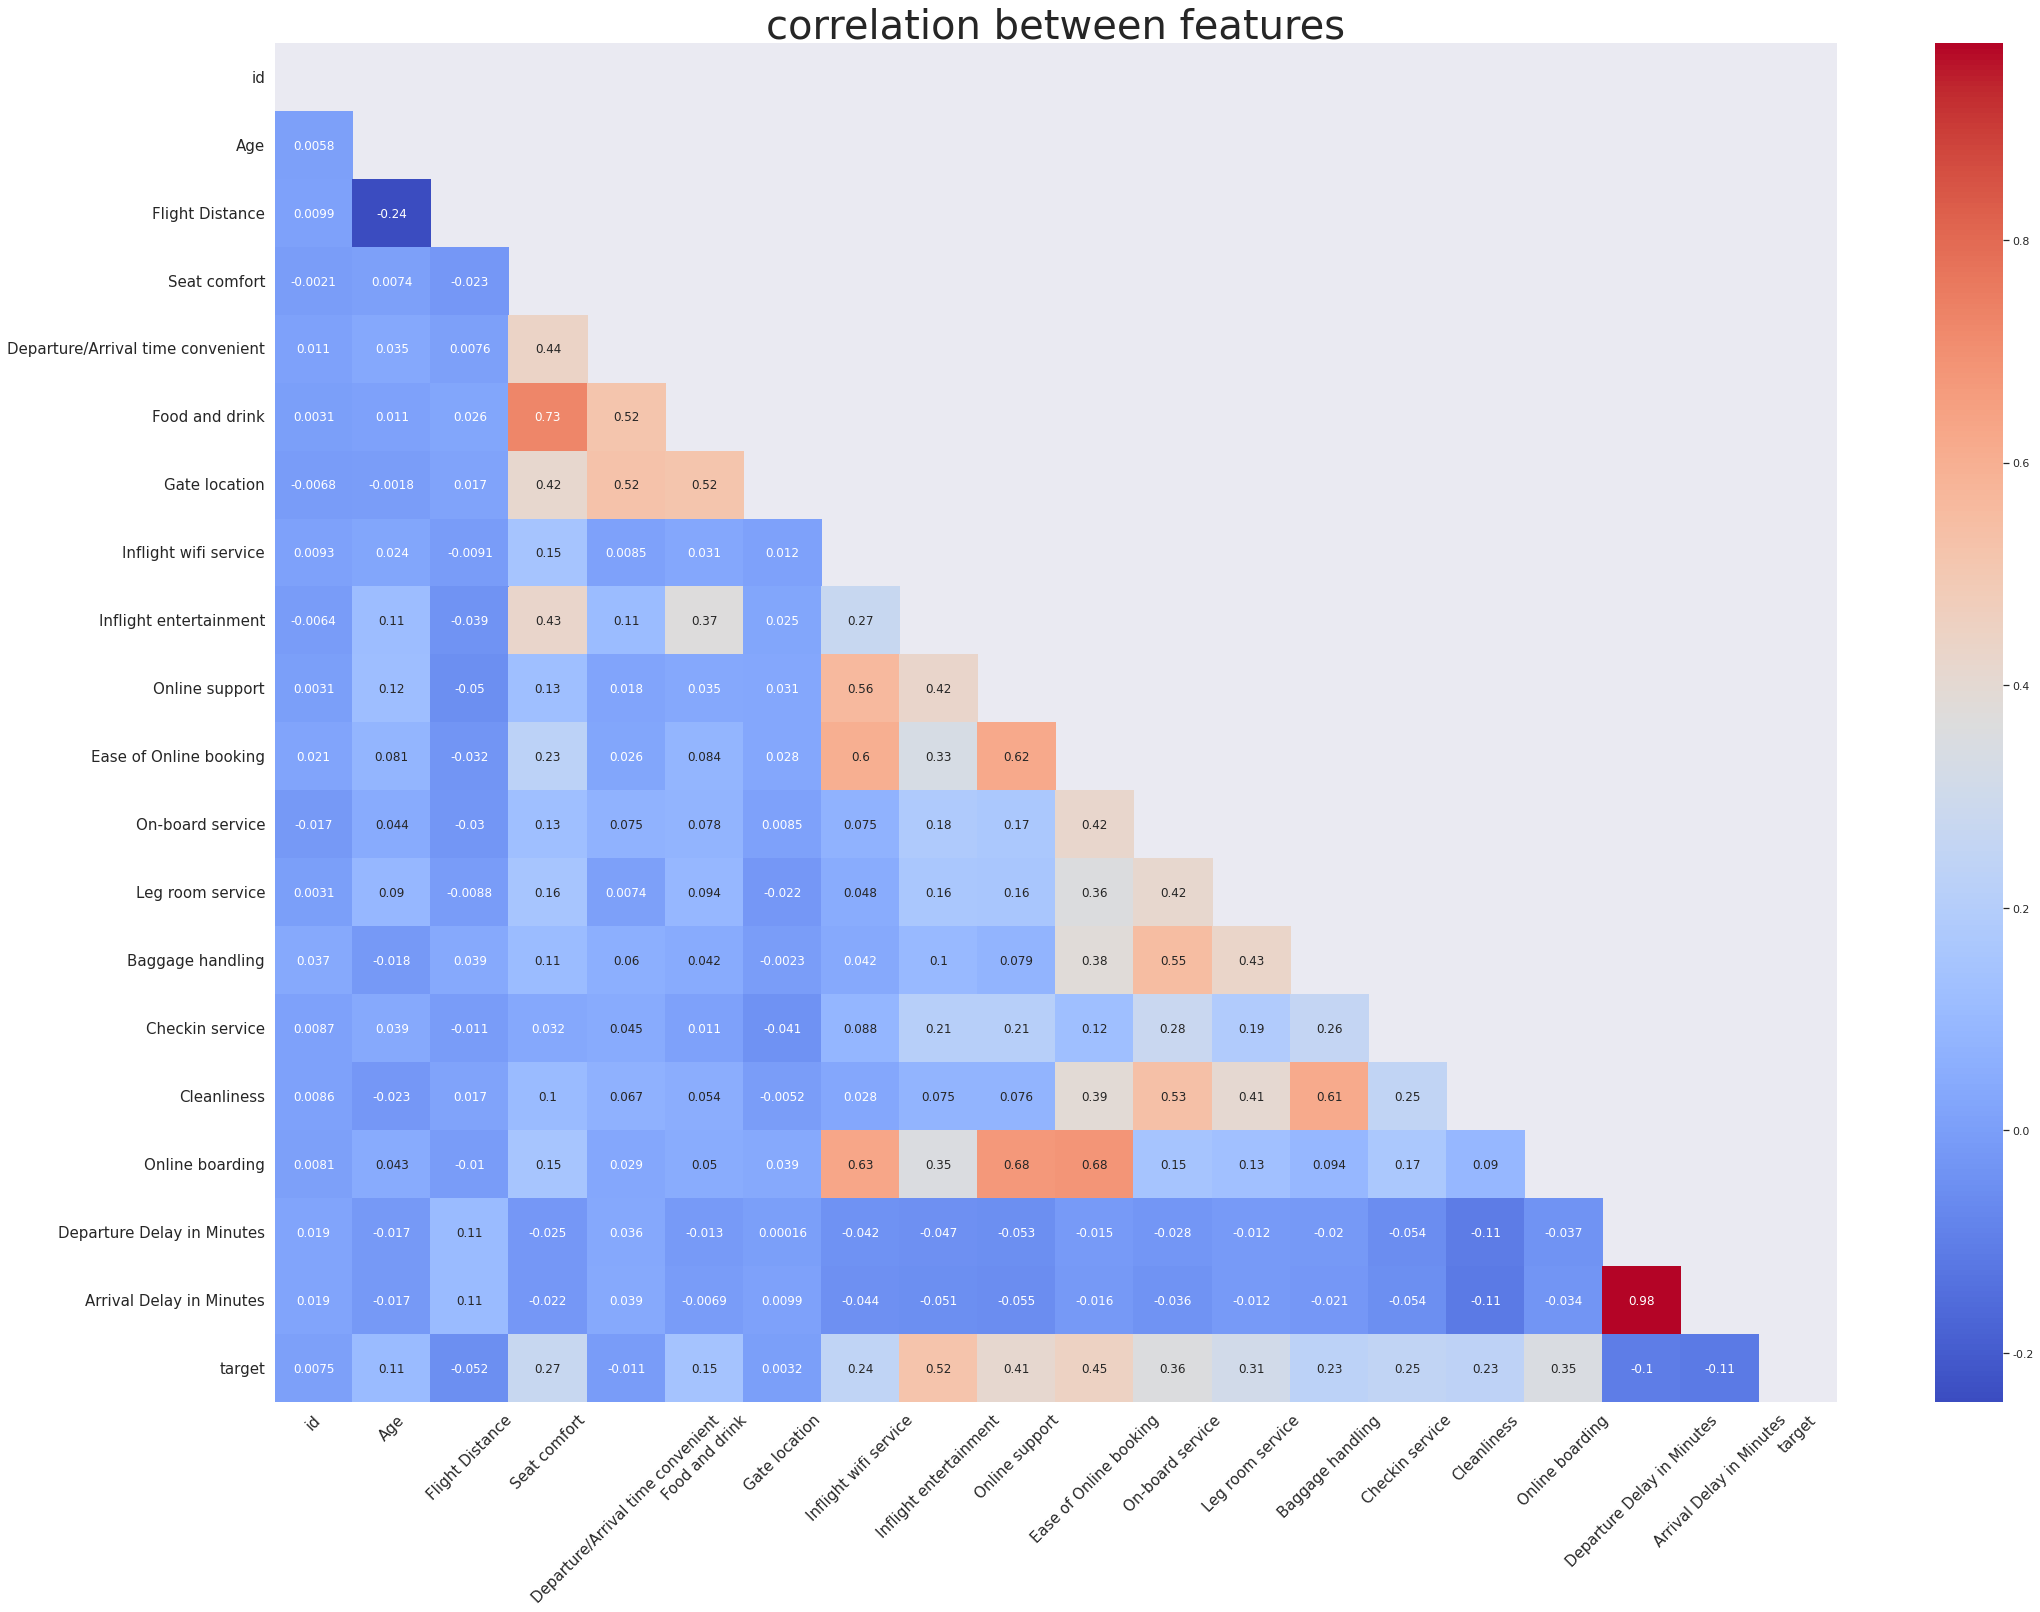

In [ ]:
#Heat Map
plt.figure(figsize=(35,25))
heat_table = df.corr()
mask = np.zeros_like(heat_table)
mask[np.triu_indices_from(mask)] = True
heatmap_ax = sns.heatmap(heat_table, annot=True, mask = mask, cmap='coolwarm')
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15)
plt.title('correlation between features', fontsize=40)
plt.show()


## 2.2 데이터 편중 및 스케일 확인

방법: Data Histogram으로 확인 

결론: Flight Distance, Delay minuite의 값들은 좌편향 되어 있으며, 리커트척도 값들과 scale이 크게 차이난다. 따라서, 평가지표로 반영할 경우 스케일링 및 척도변환이 필요할 것이다.

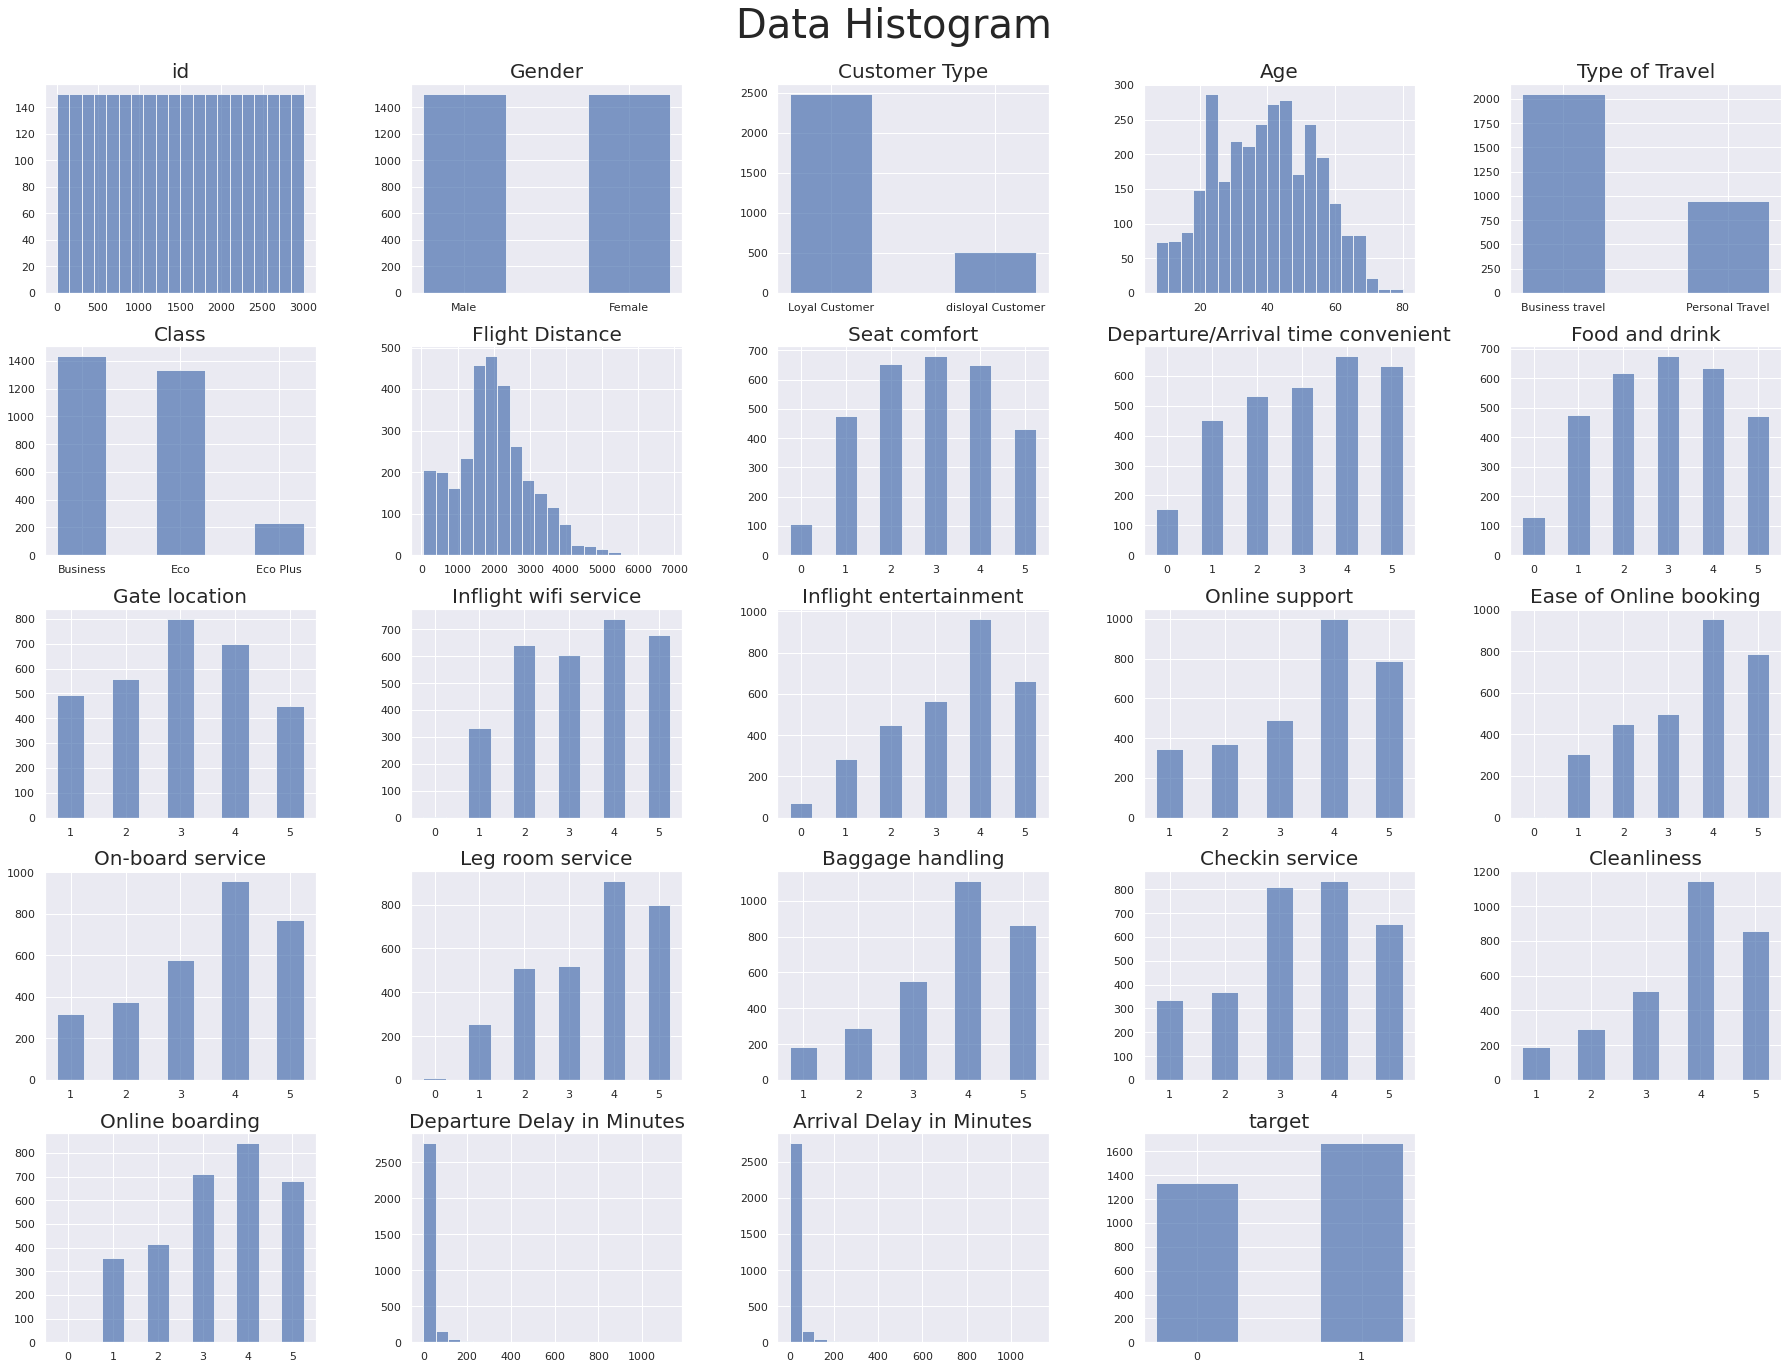

In [ ]:
plt.figure(figsize=(25, 20))
plt.suptitle("Data Histogram", fontsize = 40)

cols = df.columns
for i in range(len(cols)):
    plt.subplot(5, 5, i+1) # subplot는 여러 그래프를 한 그림에 표현
    plt.title(cols[i], fontsize=20) 
    if len(df[cols[i]].unique()) > 20: 
        plt.hist(df[cols[i]], bins=20, color='b', alpha=0.7) 
        
    else: 
        temp = df[cols[i]].value_counts() 
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
        
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
#1. 종속변수 확인 및 전처리 코드 및 결과.
del df["Food and drink"],df["Online support"],df["Ease of Online booking"],df["Departure Delay in Minutes"] 
df

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Gate location,Inflight wifi service,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Arrival Delay in Minutes,target
0,1,Female,disloyal Customer,22,Business travel,Eco,1599,3,0,3,4,3,5,4,4,4,5,4,0.0,0
1,2,Female,Loyal Customer,37,Business travel,Business,2810,2,4,4,1,4,5,4,2,1,5,2,18.0,0
2,3,Male,Loyal Customer,46,Business travel,Business,2622,1,1,1,4,5,4,4,4,5,4,3,0.0,1
3,4,Female,disloyal Customer,24,Business travel,Eco,2348,3,3,3,3,3,2,4,5,3,4,3,2.0,0
4,5,Female,Loyal Customer,58,Business travel,Business,105,3,3,3,4,4,4,4,4,4,4,5,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,Male,Loyal Customer,30,Personal Travel,Eco,2377,1,5,1,1,4,3,5,3,4,2,4,225.0,0
2996,2997,Female,disloyal Customer,24,Business travel,Eco,1643,2,4,4,5,3,2,2,4,1,3,5,13.0,0
2997,2998,Female,disloyal Customer,22,Business travel,Eco,1442,2,2,3,4,2,3,2,3,4,3,4,67.0,0
2998,2999,Female,disloyal Customer,33,Business travel,Business,2158,2,2,5,4,2,5,2,5,5,5,4,3.0,0


#3.'0'에 대한 해석 및 처리

##3.1 '0'값을 Null 값으로 판단한 근거
가설 : 0은 null값 대신 입력된 것이다.

가설 검증 근거

1. 점수상 0값은 critical 한 점수 임에도 불구하고 3~4개 항목에 0점을 주었음에도 불구하고 최종 만족 응답인 경우가 여러번 존재한다.
2. Count Plot으로 확인.
3. 일반적으로 만족도 조사에 사용되는 리커트 척도는 1~ 5 또는 1~ 7점으로 조사한다.

In [ ]:
# 4개이상의 지표에서 0값을 주었으나 최종 Target=1 '만족'을 갖는 고객의 수 확인
new_df = pd.read_csv("/content/train.csv")

id_list = []
for i in range(len(new_df)):
  count = 0
  if new_df.iloc[i][-1] == 1:
    for j in range(7, 21):
      if new_df.iloc[i][j] == 0:
        count += 1
  if count > 3:
    id_list.append(i)

print('명 수 :', len(id_list),'명')
new_df.iloc[id_list]

명 수 : 21 명


,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target
19,20,Male,disloyal Customer,26,Business travel,Business,2924,0,0,0,2,1,0,1,1,5,5,4,5,4,1,0,2.0,1
121,122,Female,Loyal Customer,34,Business travel,Eco Plus,2992,0,0,0,3,2,0,2,2,5,5,4,4,5,2,3,14.0,1
341,342,Female,Loyal Customer,63,Personal Travel,Eco Plus,433,0,0,0,3,1,0,1,1,5,1,1,4,5,1,40,63.0,1
464,465,Male,disloyal Customer,23,Business travel,Business,1686,0,0,0,3,3,0,4,3,5,4,5,4,4,3,0,0.0,1
515,516,Female,disloyal Customer,30,Business travel,Business,2206,0,0,0,4,3,0,3,3,5,5,4,5,5,3,0,0.0,1
715,716,Male,disloyal Customer,23,Business travel,Eco,2665,0,0,0,2,3,0,3,3,5,4,4,4,4,3,46,52.0,1
974,975,Female,disloyal Customer,26,Business travel,Business,1500,0,0,0,2,2,0,2,2,3,2,5,5,5,2,0,0.0,1
1328,1329,Male,Loyal Customer,30,Business travel,Eco,1512,0,0,0,2,5,0,5,5,5,3,2,4,3,5,0,0.0,1
1329,1330,Female,Loyal Customer,13,Personal Travel,Eco,1497,0,0,0,5,2,0,2,2,4,5,2,5,2,2,0,0.0,1
1628,1629,Male,disloyal Customer,21,Business travel,Business,2718,0,0,0,3,5,0,5,5,3,4,5,5,5,5,0,0.0,1


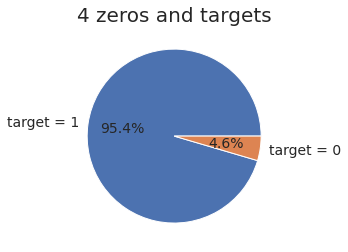

In [ ]:
#4개 항목에서 0을 준 사람들의 최종 Target값 분포 비율 확인
target_1 = 0
total = 0

for i in range(len(df)):
  zero = False
  count = 0
  for j in range(7, 21):
    if original_df.iloc[i][j] == 0:
      count += 1
      if count == 4:
        zero = True
  if zero == True:
    total += 1
    if df.iloc[i][-1] == 1:
      target_1 += 1

ratio = round((target_1 / total) * 100, 2)

plt.pie([ratio, (100-ratio)], labels = ['target = 1', 'target = 0'], autopct='%.1f%%', textprops={'fontsize': 14})
plt.title('4 zeros and targets', size = 20)

plt.show()

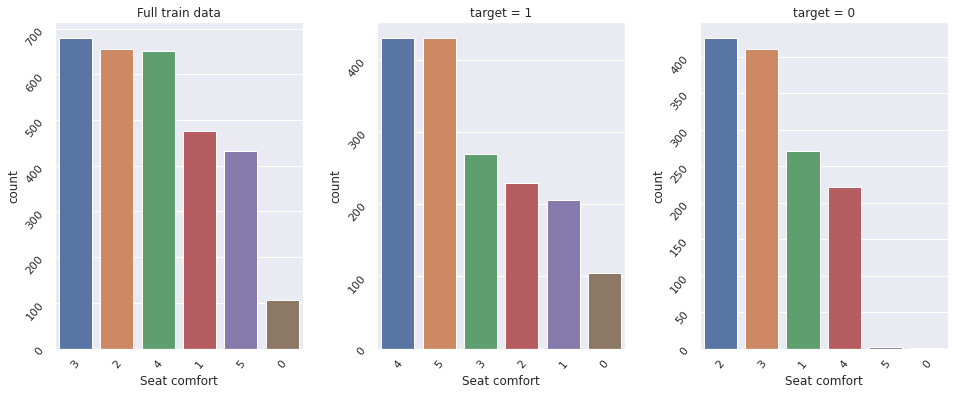

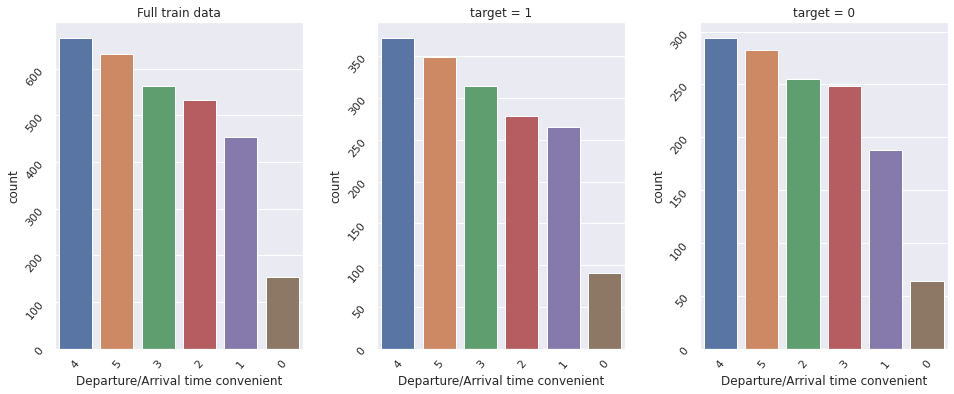

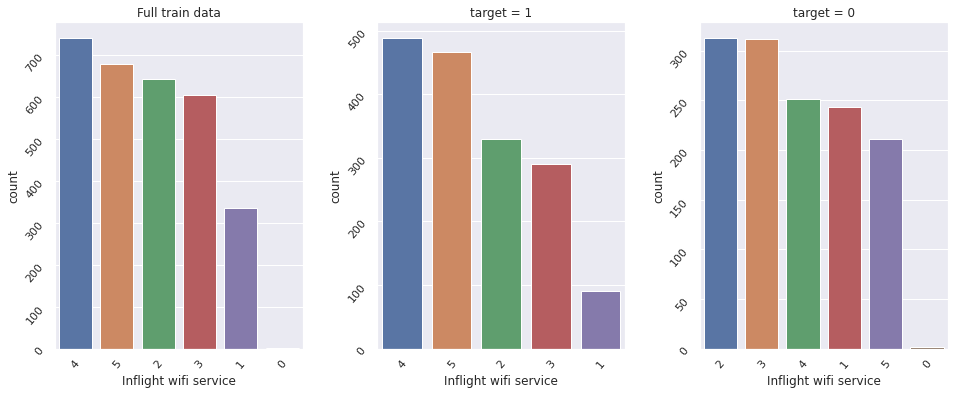

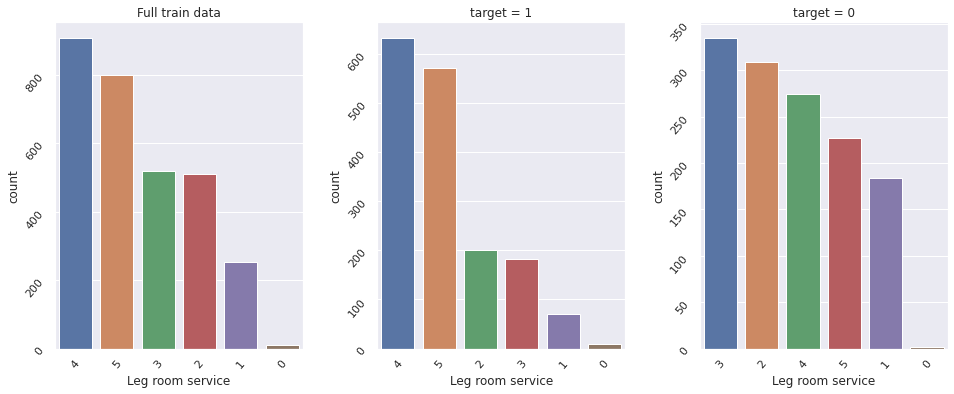

In [ ]:
zero = df
num_1 = df[df['target']==1]
num_0 = df[df['target']==0]

def count_plot(column):
    f, ax = plt.subplots(1, 3, figsize=(16, 6))
    sns.countplot(x = column,
                data = zero,
                ax = ax[0],
                order = zero[column].value_counts().index
                )    
    ax[0].set_title('Full train data')
    ax[0].set_ylabel('count')
    ax[0].tick_params(rotation=50)


    sns.countplot(x = column, data = num_1,
                ax = ax[1],
                order = num_1[column].value_counts().index)   
    ax[1].set_title('target = 1')
    ax[1].set_ylabel('count')
    ax[1].tick_params(rotation=50)

    sns.countplot(x = column,
                data = num_0,
                ax = ax[2],
                order = num_0[column].value_counts().index)
    ax[2].set_title('target = 0')
    ax[2].set_ylabel('count')
    ax[2].tick_params(rotation=50)

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

count_plot('Seat comfort')
count_plot('Departure/Arrival time convenient')
count_plot('Inflight wifi service')
count_plot('Leg room service')

##3.2 Hot Deck (KNN method)를 활용한 Null값 처리

Null 값을 가지는 지표를 제외한 다른 항목들을 기준으로 가장 유사한 평가를 내린 고객을 찾아 해당 고객의 평가 값으로 Null값을 대체 한다.

In [ ]:
from sklearn.impute import KNNImputer
data = df.replace(0, np.NaN)
imputer = KNNImputer(n_neighbors=1)

KNN_data = imputer.fit_transform(data.iloc[:,7:16])
df.iloc[:,7:16] = KNN_data
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Gate location,Inflight wifi service,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Arrival Delay in Minutes,target
0,1,Female,disloyal Customer,22,Business travel,Eco,1599,3.0,4.0,3.0,4.0,3.0,5.0,4.0,4.0,4.0,5,4,0.0,0
1,2,Female,Loyal Customer,37,Business travel,Business,2810,2.0,4.0,4.0,1.0,4.0,5.0,4.0,2.0,1.0,5,2,18.0,0
2,3,Male,Loyal Customer,46,Business travel,Business,2622,1.0,1.0,1.0,4.0,5.0,4.0,4.0,4.0,5.0,4,3,0.0,1
3,4,Female,disloyal Customer,24,Business travel,Eco,2348,3.0,3.0,3.0,3.0,3.0,2.0,4.0,5.0,3.0,4,3,2.0,0
4,5,Female,Loyal Customer,58,Business travel,Business,105,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4,5,0.0,1


#4.기타 Feature 값들의 해석 및 처리 (Delay minutes / Distance / Age)

3-1. (Delay in Minuites) 반영시 scaling 및 1~5점 표준화 필요

3-2. (Flight Distance) 고객이 사전 인지하는 요소이기 때문에 평가지표로서 크게 반영되지는 않을 것.

(단, 장거리 일수록 seat comfort 등의 요소와 상관관계가 있을 수 있을 것이다. =>  위의 Heat map에서 기각)

3-3. (Age) Box Plot으로 성별에 따른 target 분포 차이가 나는지 확인

*
데이터 전 처리전, 상관도(가중치)가 너무 작은 항목들은 분석 지표에서 누락시켜도 무방하므로 2번까지의 데이터를 사용하여 먼저 가중치 분석 및 성능 차이를 확인해 보았다.

결론: 위 3항목의 feature 들은 가장 상관도가 낮은 항목(0.2이하)이며, 각 그룹간의 성능 차이가 매우 적으므로 feature 값에서 제외하기로 한다.

=> G2 채택 

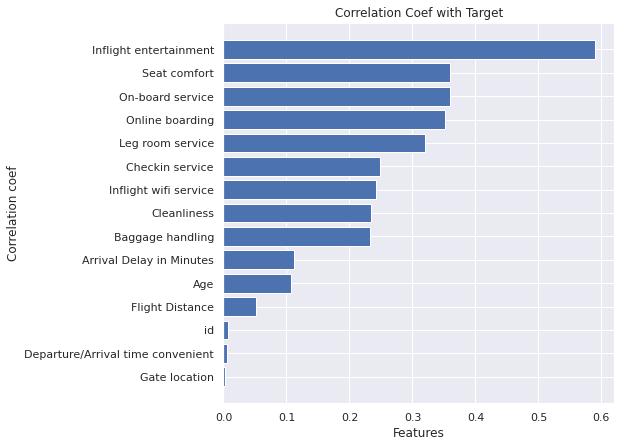

In [ ]:
c = df.corr().iloc[-1]
c = np.abs(c)
c.sort_values(ascending = True, inplace = True)
c = c[:-1]

plt.figure(figsize=(7,7))
plt.barh(c.index, c.values)

plt.title('Correlation Coef with Target')
plt.xlabel('Features')
plt.ylabel('Correlation coef')
plt.show()

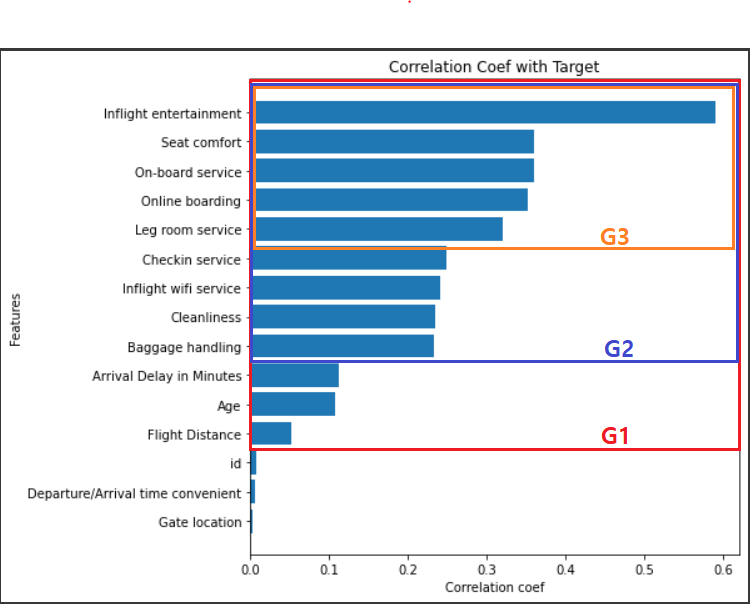

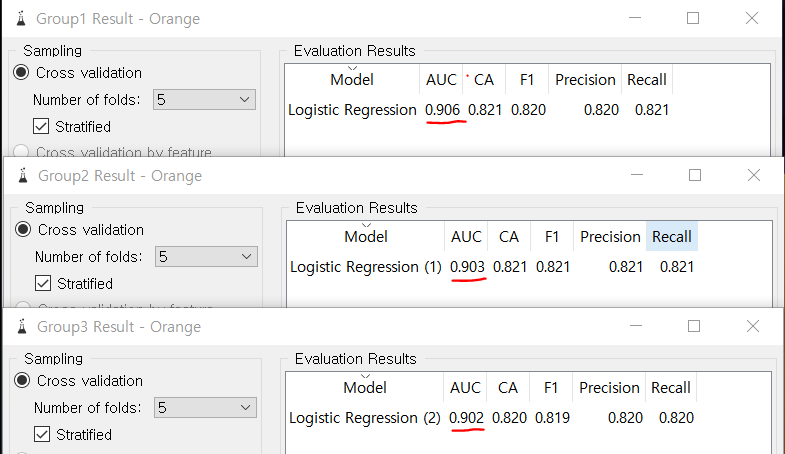

In [ ]:
del df["Flight Distance"],df["Age"],df["Arrival Delay in Minutes"],df["id"],df["Gate location"],df["Departure/Arrival time convenient"]
df
df.to_csv('edited_final.csv', index = True)

#5.Object Feature에 대한 해석 및 처리(Gender, Customer Type, Type of Travel, Class)

- 해당 Feature 들은 점수로 반영하는 것은 부적합하므로, 분석 그룹 설정 지표로 사용하여 그룹별 차이가 나타나는지 확인해 보았다.

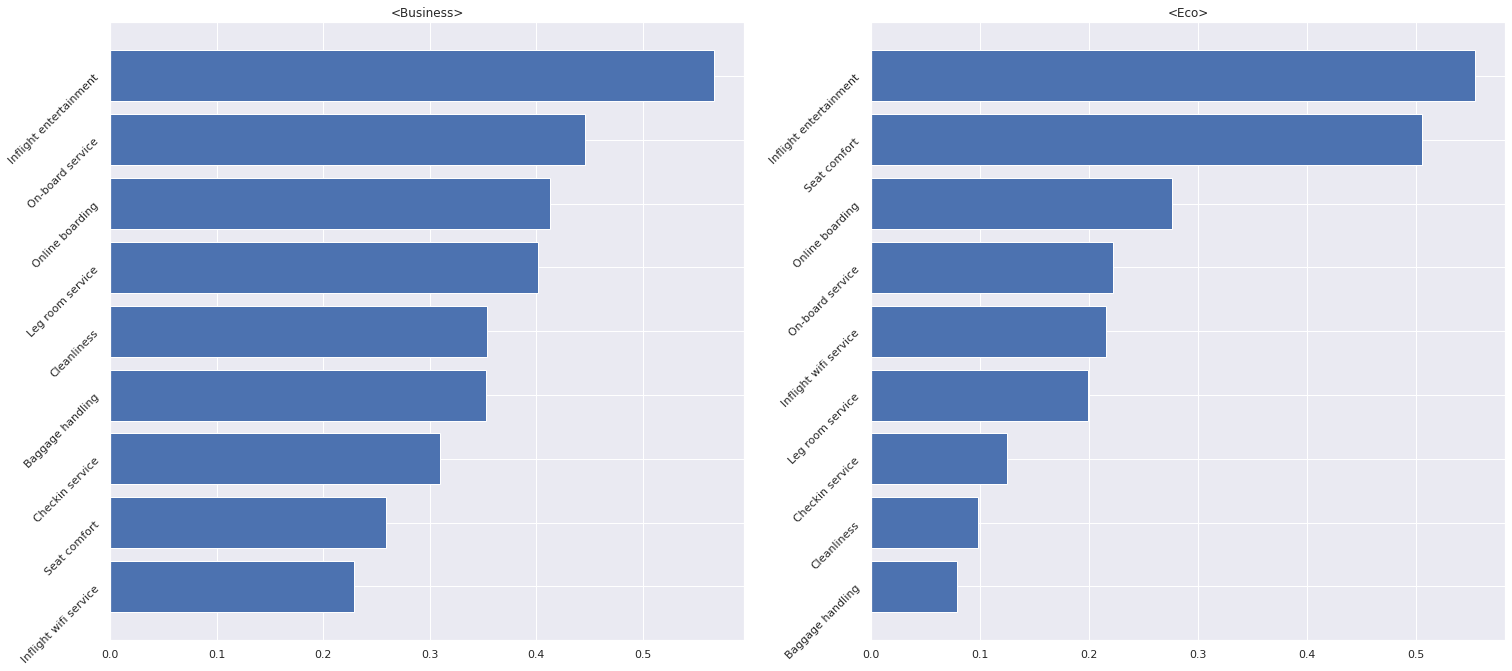

In [ ]:
#4-1 Class.
비지니스 = df.loc[df['Class']=='Business']
에코 = df.loc[df['Class']=='Eco']
에코플러스 = df.loc[df['Class']=='Eco Plus']

plt.figure(figsize=(25,25))

c = 비지니스.corr().iloc[-1]
c = np.abs(c)
c.sort_values(ascending = True, inplace = True)
c = c[:-1]

plt.subplot(2, 2, 1)
plt.barh(c.index, c.values)
plt.title("<Business>")
plt.yticks(rotation='45')

c = 에코.corr().iloc[-1]
c = np.abs(c)
c.sort_values(ascending = True, inplace = True)
c = c[:-1]

plt.subplot(2, 2, 2)
plt.barh(c.index, c.values)
plt.title("<Eco>")
plt.yticks(rotation='45')
plt.show()

<해석>

Business 그룹과 Economy 그룹을 비교할 경우, 지표들의 상관도 순위에서 차이를 보인다.

대표적으로 Business그룹은 Seat comfort의 상관도가 낮은반면 Eco 그룹은 상관도가 높게 나왔다. 이는 Business 좌석의 경우 기본적으로 Seat comfort 좋고 따라서 이에 대한 평가 variation이 적기 떄문이라고 추론할 수 있다.

또한 전반적인 평가에 있어 Business 그룹이 Eco그룹에 비해 전영역에 대해 고르게 평가함을 확인 할 수 있다.

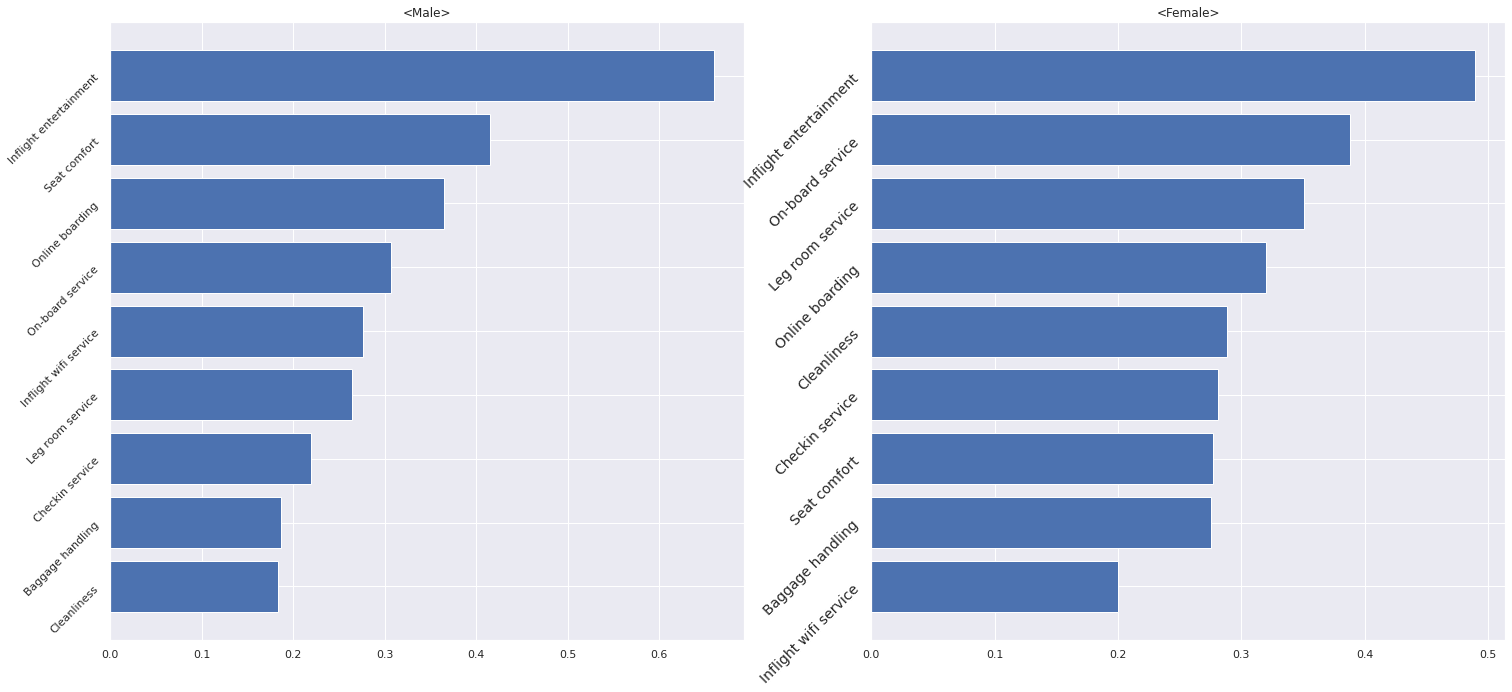

In [ ]:
#4-2. Gender
남 = df.loc[df['Gender']=='Male']
여 = df.loc[df['Gender']=='Female']

plt.figure(figsize=(25,25))

c = 남.corr().iloc[-1]
c = np.abs(c)
c.sort_values(ascending = True, inplace = True)
c = c[:-1]

plt.subplot(2, 2, 1)
plt.barh(c.index, c.values)
plt.title("<Male>")
plt.yticks(rotation='45')


c = 여.corr().iloc[-1]
c = np.abs(c)
c.sort_values(ascending = True, inplace = True)
c = c[:-1]

plt.subplot(2, 2, 2)
plt.barh(c.index, c.values)
plt.title("<Female>")
plt.yticks(rotation='45', fontsize = 14)
plt.show()

<해석>

Male 그룹과 Female 그룹을 비교할 경우, 지표들의 상관도 순위에서 차이를 보인다.

대표적으로 Male그룹은 Seat comfort의 상관도가 낮은반면 Female 그룹은 상관도가 높게 나왔다. 이는 일반적으로 남성의 체격이 더 크기때문에 Seat comfort에 민감한 것으로 생각할 수 있다.

한편, Cleanliness 또한 남/여 그룹에서 차이를 나타냈는데, 이를 통해 남성은 상대적으로 청결도에 크게 민감하지 않다는 점을 추론 할 수 있다. 

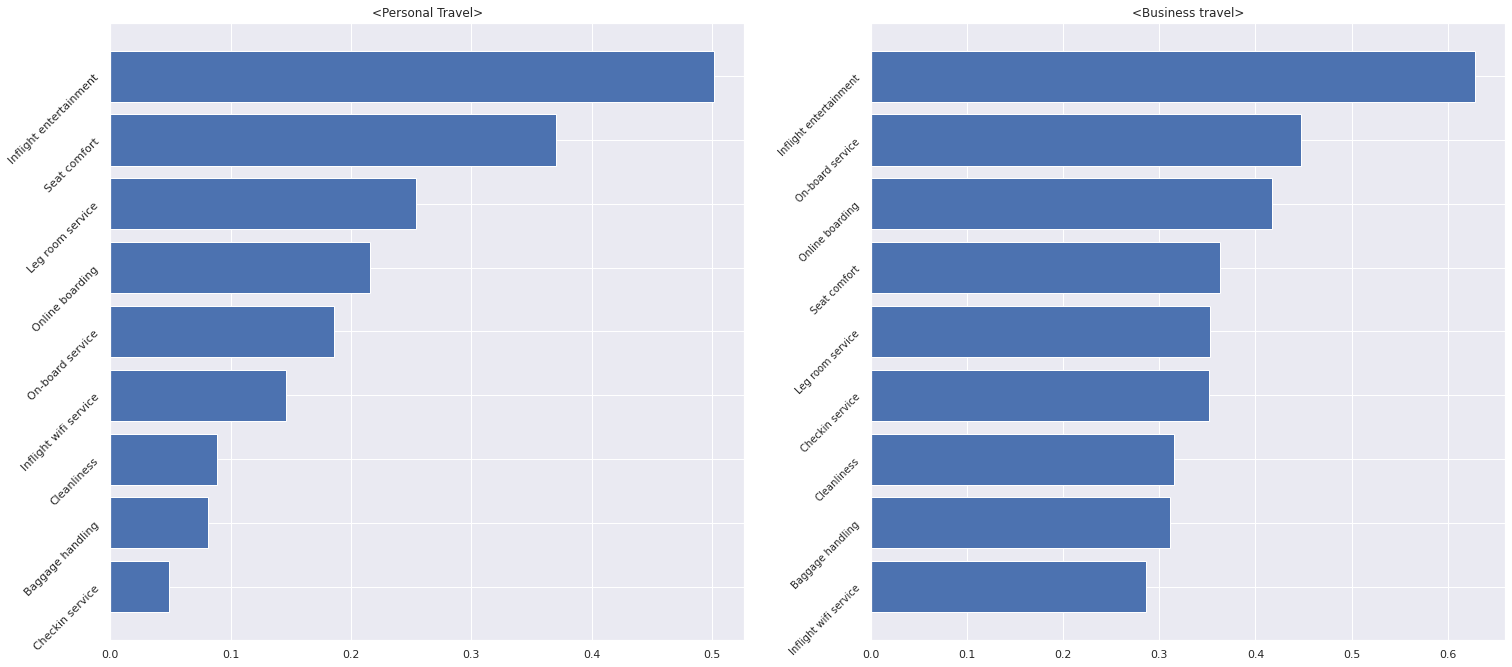

In [ ]:
#4-3. Type of Travel
p_travel = df.loc[df['Type of Travel']=='Personal Travel']
b_travel = df.loc[df['Type of Travel']=='Business travel']

plt.figure(figsize=(25,25))

c = p_travel.corr().iloc[-1]
c = np.abs(c)
c.sort_values(ascending = True, inplace = True)
c = c[:-1]

plt.subplot(2, 2, 1)
plt.barh(c.index, c.values)
plt.yticks(rotation='45')
plt.title('<Personal Travel>')

c = b_travel.corr().iloc[-1]
c = np.abs(c)
c.sort_values(ascending = True, inplace = True)
c = c[:-1]

plt.subplot(2, 2, 2)
plt.barh(c.index, c.values)
plt.yticks(rotation='45', fontsize = 10)
plt.title("<Business travel>")
plt.show()

<해석>

비지니스 목적의 고객의 경우가 전반적인 항목에 대해 고르게 평가하는 경향성 나타남


#6.결론 및 고찰


##6.1 최종 데이터 전처리 결과.
- 1. 다중공선성 지표 제거
- 2. '0'값(null값) 대체 (Hot Deck method)
- 3. 의미 없는 Feature 값 제거

##6.2 데이터 전처리 전/후 분석 성능 비교 결과

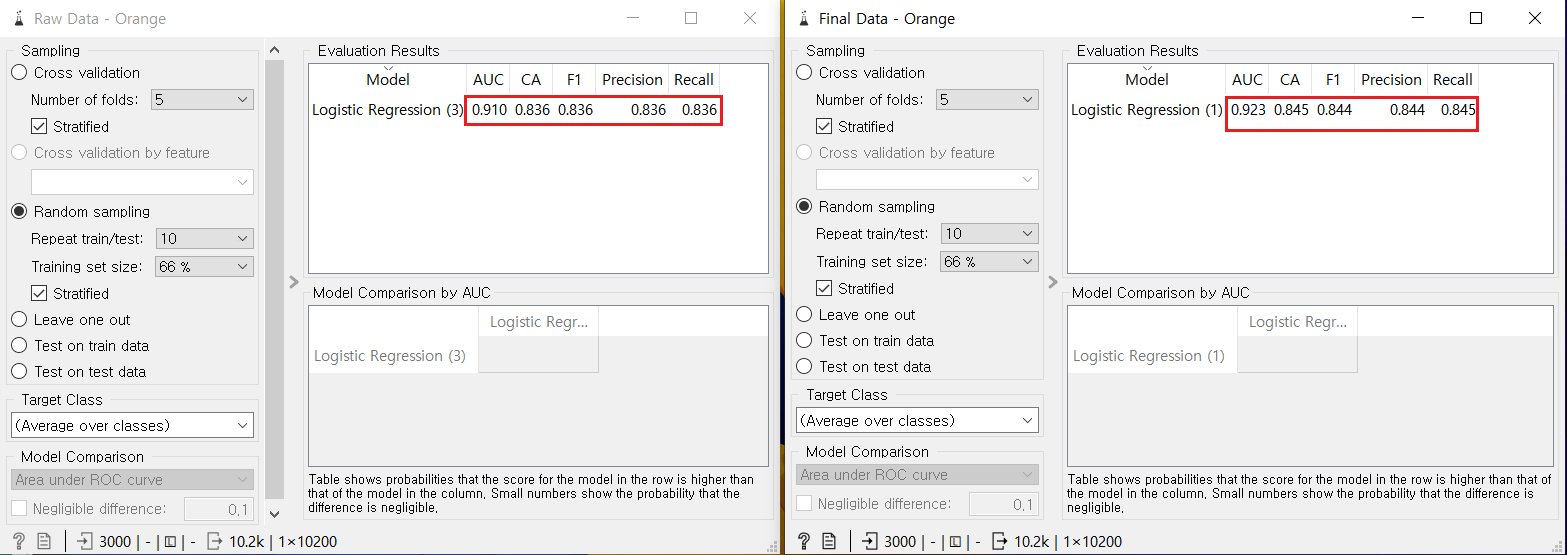

##6.3 결론 및 고찰

1.데이터 전처리 전후를 기준으로 성능 값이 크게 증가하지는 않았다.

이는 3000*24개 데이터 중 값을 변환 해 준 데이터가 약 180개(0.25%) 밖에 되지 않았기 때문일 것으로 생각된다.

그러나, 전처리 과정을 통해 약 10*3000개의 데이터(전체의 약 41%)를 제거한 후 분석을 진행하였으므로 분석 비용 및 시간 측면에서 효율성이 증대되었을 것이다.


2.Object Feature의 결과를 보면, 고객의 소속 그룹에 따라 중요하게 평가하는 척도가 다르게 나타남을 확인 할 수 있었다. 

따라서 실제 항공사의 경우 이러한 그룹별 중요 feature 들에 맞춘 서비스를 강화하고 약점을 보완하거나, 마케팅의 키워드로 사용함으로써 고객 만족도 향상 및 신규 고객 유치를 기대할 수 있을 것으로 생각된다.